# Charity classification analysis

Analysis using a new dataset that classifies and tags all active and inactive charities according to their activity/sector. This analysis explores how number of charities in specific activities have changed, whether specific sectors were more "trendy" at some point and whether others have died out.

For this analysis we need a number of different modules. 

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import os
import ast
from scipy import stats #for streamgraph

%matplotlib inline

## Import data

We will define the root of the repository, so that we can import files from the folder more easily. 

In [26]:
root = os.path.abspath(os.path.join(os.getcwd(), ".."))

First we need to [import data](https://charityclassification.org.uk/data/data-downloads/) from the Charity Classification project. We will focus on the ICNPTSO classifications for now. 

In [27]:
active_icnptso = pd.read_csv(os.path.join(root, "data\\raw\\charities_active-icnptso.csv"))
inactive_icnptso = pd.read_csv(os.path.join(root, "data\\raw\\charities_inactive-icnptso.csv"))
icnptso = pd.read_csv(os.path.join(root, "data\\raw\\icnptso.csv"))

Then we import data from the Charity Commission register using [FindThatCharity](https://findthatcharity.uk/orgid/type/registered-charity). This includes all active and removed charities registered in the UK as of November 2021. 

In [28]:
charities = pd.read_csv(os.path.join(root, "data\\raw\\registered-charity.csv"))

C:\Users\lisa.hornung\anaconda3\envs\py3_charity\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,3,7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cleaning

### Check

First we want to get a feel for how big the different dataframes are and what variables they contain.

In [29]:
dataframes = [active_icnptso,inactive_icnptso,icnptso, charities ]

for df in dataframes:
    print(len(df))
    print(df.head(2))
    print("")
    print("")

202222
           org_id icnptso_code  icnptso_code_probability icnptso_code_source
0  GB-CHC-1000000          B32                     0.358            ml_model
1  GB-CHC-1000001          A11                     0.836            ml_model


191438
           org_id icnptso_code  icnptso_code_probability icnptso_code_source
0  GB-CHC-1000004          A11                     1.000            ml_model
1  GB-CHC-1000006          D13                     0.697            ml_model


127
  Section Group Sub-group                                             Title  \
0       A   NaN       NaN  Culture, communication and recreation activities   
1       A   A10       NaN                                  Culture and arts   

           Notes  
0  ICNPO Group 1  
1            NaN  


394035
               id                         name charityNumber companyNumber  \
0  GB-CHC-1000000  THE ROYAL ANNIVERSARY TRUST       1000000           NaN   
1  GB-CHC-1000001          THE ARTS FOUNDATION       100

### Merging

Now we are going to merge classifications for active and inactive into one dataframe.

In [30]:
all_icnptso = pd.concat([active_icnptso,inactive_icnptso])
all_icnptso.head(2)

,org_id,icnptso_code,icnptso_code_probability,icnptso_code_source
0,GB-CHC-1000000,B32,0.358,ml_model
1,GB-CHC-1000001,A11,0.836,ml_model


Then we want to merge the classifications to data from the Charity Commission register and start slowly building our dataframe (df) for analysis.

In [31]:
#select only columns we are interested in
df = charities[['id', 'name', 'charityNumber', 'dateRegistered', 'dateRemoved', 'active']]

#join classification data
df = pd.merge(df, all_icnptso, left_on= df["id"], right_on=all_icnptso["org_id"], how='left')

#remove columns we don't need
df = df.drop(columns=["key_0", "org_id"])

len(df)

394035

Now we want to clean up the icnptso categories a bit more and merge in the titles.

In [32]:
#get group
df["icnptso_group"] = df["icnptso_code"].str[0]

#get title for group
df_join = icnptso.loc[icnptso["Group"].isna()][["Section", "Title"]]
df = pd.merge(df, df_join, left_on = df["icnptso_group"], right_on=df_join["Section"], how='left')
df = df.drop(columns=["key_0", "Section"]).rename(columns={"Title": "icnptso_group_title"})

### Dates

In [33]:
#convert columns to pandas datetime
df["dateRemoved"] = pd.to_datetime(df["dateRemoved"])
df["dateRegistered"] = pd.to_datetime(df["dateRegistered"])

#get years from date
df["yearRemoved"] = df["dateRemoved"].dt.year
df["yearRegistered"] = df["dateRegistered"].dt.year

#combine years before 1960 (as E&W database only starts then)
df["yearRemovedCombined"] = df["yearRemoved"]
df.loc[df["yearRemoved"] < 1960, "yearRemovedCombined"] = 1960 
df["yearRegisteredCombined"] = df["yearRegistered"]
df.loc[df["yearRegistered"] < 1960, "yearRegisteredCombined"] = 1960 

## Analysis

### Number of registrations by year and group

In [34]:
table = df.groupby(["yearRegisteredCombined", "icnptso_group_title"])["id"].count()
table = pd.DataFrame(table).unstack()

#export table
table.to_csv(os.path.join(root, "data\\processed\\registrations-by-year-combined-icnptso.csv"))

table

id  \
icnptso_group_title    Business, professional and labour organizations   
yearRegisteredCombined                                                   
1960                                                              11.0   
1961                                                              24.0   
1962                                                             121.0   
1963                                                              98.0   
1964                                                              62.0   
...                                                                ...   
2017                                                              18.0   
2018                                                              11.0   
2019                                                              18.0   
2020                                                              11.0   
2021                                                              12.0   

                                                                                \
icnptso_group_title    Civic, advocacy, political and international activities   
yearRegisteredCombined                                                           
1960                                                                147.0        
1961                                                                347.0        
1962                                                                989.0        
1963                                                               2236.0        
1964                                                               1190.0        
...                                                                   ...        
2017                                                                871.0        
2018                                                                601.0        
2019                                                                644.0        
2020                                                                698.0        
2021                                                                444.0        

                                                                                   \
icnptso_group_title    Community and economic development, and housing activities   
yearRegisteredCombined                                                              
1960                                                                157.0           
1961                                                                368.0           
1962                                                               1774.0           
1963                                                               2727.0           
1964                                                               1610.0           
...                                                                   ...           
2017                                                                777.0           
2018                                                                592.0           
2019                                                                689.0           
2020                                                                703.0           
2021                                                                390.0           

                                                                         \
icnptso_group_title    Culture, communication and recreation activities   
yearRegisteredCombined                                                    
1960                                                              207.0   
1961                                                              281.0   
1962                                                             1000.0   
1963                                                             1477.0   
1964                                                             1081.0   
...                                                                 ...   
2017            

### Removals per year and group

In [35]:
table = df.groupby(["yearRemovedCombined", "icnptso_group_title"])["id"].count()
table = pd.DataFrame(table).unstack()

#export table
table.to_csv(os.path.join(root, "data\\processed\\removals-by-year-combined-icnptso.csv"))

table

id  \
icnptso_group_title Business, professional and labour organizations   
yearRemovedCombined                                                   
1961.0                                                          2.0   
1962.0                                                          4.0   
1963.0                                                          NaN   
1964.0                                                          1.0   
1965.0                                                          1.0   
...                                                             ...   
2017.0                                                         16.0   
2018.0                                                         18.0   
2019.0                                                         17.0   
2020.0                                                         11.0   
2021.0                                                         12.0   

                                                                             \
icnptso_group_title Civic, advocacy, political and international activities   
yearRemovedCombined                                                           
1961.0                                                            25.0        
1962.0                                                             9.0        
1963.0                                                            14.0        
1964.0                                                            13.0        
1965.0                                                             7.0        
...                                                                ...        
2017.0                                                           467.0        
2018.0                                                           576.0        
2019.0                                                           631.0        
2020.0                                                           400.0        
2021.0                                                           363.0        

                                                                                \
icnptso_group_title Community and economic development, and housing activities   
yearRemovedCombined                                                              
1961.0                                                            24.0           
1962.0                                                             9.0           
1963.0                                                            17.0           
1964.0                                                            16.0           
1965.0                                                            16.0           
...                                                                ...           
2017.0                                                           393.0           
2018.0                                                           539.0           
2019.0                                                           573.0           
2020.0                                                           433.0           
2021.0                                                           311.0           

                                                                      \
icnptso_group_title Culture, communication and recreation activities   
yearRemovedCombined                                                    
1961.0                                                          45.0   
1962.0                                                           9.0   
1963.0                                                          11.0   
1964.0                                                          11.0   
1965.0                                                           7.0   
...                                                              ...   
2017.0                                                         555.0   
2018.0                                                         616.0   
2019.0                

### charities active by year

In [94]:
dicts = {}
keys = list(df["icnptso_group_title"].unique())
all_values = []

#iterate through all groups
for item in keys:
    
    #filter for group
    df_filter = df.loc[df["icnptso_group_title"] == item]

    #empty list to store value counts
    values = []
    
    #iterate through all years and count when active in that year
    for year in range(1960, 2022):
        value = sum((df_filter["yearRegistered"]<= year) & ( (df_filter["yearRemoved"] > year) | (df_filter["active"]==True)))
        values.append(value)

    all_values.append(values)

#store keys and values in dictionary
for i in range(len(keys)):
    dicts[keys[i]] = all_values[i]

#convert dictionary to dataframe
char_year_icnptso =  pd.DataFrame.from_dict(dicts)

In [95]:
#add total, year and 'other' column 
char_year_icnptso["total"] = char_year_icnptso.sum(axis=1)
char_year_icnptso["year"] = range(1960, 2022)

char_year_icnptso["Other"] = char_year_icnptso[['Professional, scientific, accounting and administrative services',
                                                  'Human health services',
                                                       'Other activities',
                 'Environmental protection and animal welfare activities',
                        'Business, professional and labour organizations']].sum(axis=1)

#drop empty column
char_year_icnptso = char_year_icnptso.drop(columns=char_year_icnptso.columns[12])

#save output file 
char_year_icnptso.to_csv(os.path.join(root, "data\\processed\\active-charities-by-year-icnptso.csv"))

char_year_icnptso

,Education services,"Culture, communication and recreation activities",Philanthropic intermediaries and voluntarism promotion,"Civic, advocacy, political and international activities","Community and economic development, and housing activities",Social services,Religious congregations and associations,"Professional, scientific, accounting and administrative services",Human health services,Other activities,Environmental protection and animal welfare activities,"Business, professional and labour organizations",total,year,Other
0,117,207,627,147,157,219,1422,20,31,0,7,11,2965,1960,69
1,575,443,1941,469,501,378,1666,36,85,2,15,33,6144,1961,171
2,1860,1434,7654,1449,2266,1129,2861,120,328,10,95,150,19356,1962,703
3,3549,2900,12560,3671,4976,1928,4134,205,574,16,176,248,34937,1963,1219
4,4948,3970,18872,4848,6570,2713,5525,278,881,24,212,309,49150,1964,1704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,25200,27750,33822,19880,24759,21925,31738,2525,8007,634,1228,621,198089,2017,13015
58,25093,28105,33828,19902,24812,21537,32029,2535,8023,639,1243,614,198360,2018,13054
59,25072,28408,33665,19915,24928,21301,32263,2504,8135,642,1275,615,198723,2019,13171
60,25108,28930,33959,20213,25198,21557,32878,2540,8366,645,1310,615,201319,2020,13476


### Proportion changes over time

In [325]:
char_year_icnptso_prop = char_year_icnptso[['Education services',
       'Culture, communication and recreation activities',
       'Philanthropic intermediaries and voluntarism promotion',
       'Civic, advocacy, political and international activities',
       'Community and economic development, and housing activities',
       'Social services', 'Religious congregations and associations',
        'year',
       'Other']]  

char_year_icnptso_prop = char_year_icnptso_prop.set_index("year")
char_year_icnptso_prop = char_year_icnptso_prop.transpose()
char_year_icnptso_prop = (char_year_icnptso_prop / char_year_icnptso_prop.sum(axis=0)) *100

char_year_icnptso_prop = char_year_icnptso_prop.transpose()

#save output
char_year_icnptso_prop.to_csv(os.path.join(root, "data\\processed\\active-charities-proportions-by-year-icnptso.csv"))

char_year_icnptso_prop

,Education services,"Culture, communication and recreation activities",Philanthropic intermediaries and voluntarism promotion,"Civic, advocacy, political and international activities","Community and economic development, and housing activities",Social services,Religious congregations and associations,Other
year,,,,,,,,
1960,3.946037,6.981450,21.146712,4.957841,5.295110,7.386172,47.959528,2.327150
1961,9.358724,7.210286,31.591797,7.633464,8.154297,6.152344,27.115885,2.783203
1962,9.609423,7.408555,39.543294,7.486051,11.706964,5.832817,14.780946,3.631949
1963,10.158285,8.300655,35.950425,10.507485,14.242780,5.518505,11.832727,3.489138
1964,10.067141,8.077314,38.396745,9.863683,13.367243,5.519837,11.241099,3.466938
...,...,...,...,...,...,...,...,...
2017,12.721554,14.008855,17.074143,10.035893,12.498927,11.068257,16.022091,6.570279
2018,12.650232,14.168683,17.053842,10.033273,12.508570,10.857532,16.146905,6.580964
2019,12.616557,14.295275,16.940666,10.021487,12.544094,10.718940,16.235162,6.627819


In [311]:
char_year_icnptso.columns

Index(['Education services',
       'Culture, communication and recreation activities',
       'Philanthropic intermediaries and voluntarism promotion',
       'Civic, advocacy, political and international activities',
       'Community and economic development, and housing activities',
       'Social services', 'Religious congregations and associations',
       'Professional, scientific, accounting and administrative services',
       'Human health services', 'Other activities',
       'Environmental protection and animal welfare activities',
       'Business, professional and labour organizations', 'total', 'year',
       'Other'],
      dtype='object')

## Streamgraph with matplotlib

### Active by year

In [96]:
char_year_icnptso

,Education services,"Culture, communication and recreation activities",Philanthropic intermediaries and voluntarism promotion,"Civic, advocacy, political and international activities","Community and economic development, and housing activities",Social services,Religious congregations and associations,"Professional, scientific, accounting and administrative services",Human health services,Other activities,Environmental protection and animal welfare activities,"Business, professional and labour organizations",total,year,Other
0,117,207,627,147,157,219,1422,20,31,0,7,11,2965,1960,69
1,575,443,1941,469,501,378,1666,36,85,2,15,33,6144,1961,171
2,1860,1434,7654,1449,2266,1129,2861,120,328,10,95,150,19356,1962,703
3,3549,2900,12560,3671,4976,1928,4134,205,574,16,176,248,34937,1963,1219
4,4948,3970,18872,4848,6570,2713,5525,278,881,24,212,309,49150,1964,1704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,25200,27750,33822,19880,24759,21925,31738,2525,8007,634,1228,621,198089,2017,13015
58,25093,28105,33828,19902,24812,21537,32029,2535,8023,639,1243,614,198360,2018,13054
59,25072,28408,33665,19915,24928,21301,32263,2504,8135,642,1275,615,198723,2019,13171
60,25108,28930,33959,20213,25198,21557,32878,2540,8366,645,1310,615,201319,2020,13476


In [97]:
char_year_icnptso.columns

Index(['Education services',
       'Culture, communication and recreation activities',
       'Philanthropic intermediaries and voluntarism promotion',
       'Civic, advocacy, political and international activities',
       'Community and economic development, and housing activities',
       'Social services', 'Religious congregations and associations',
       'Professional, scientific, accounting and administrative services',
       'Human health services', 'Other activities',
       'Environmental protection and animal welfare activities',
       'Business, professional and labour organizations', 'total', 'year',
       'Other'],
      dtype='object')

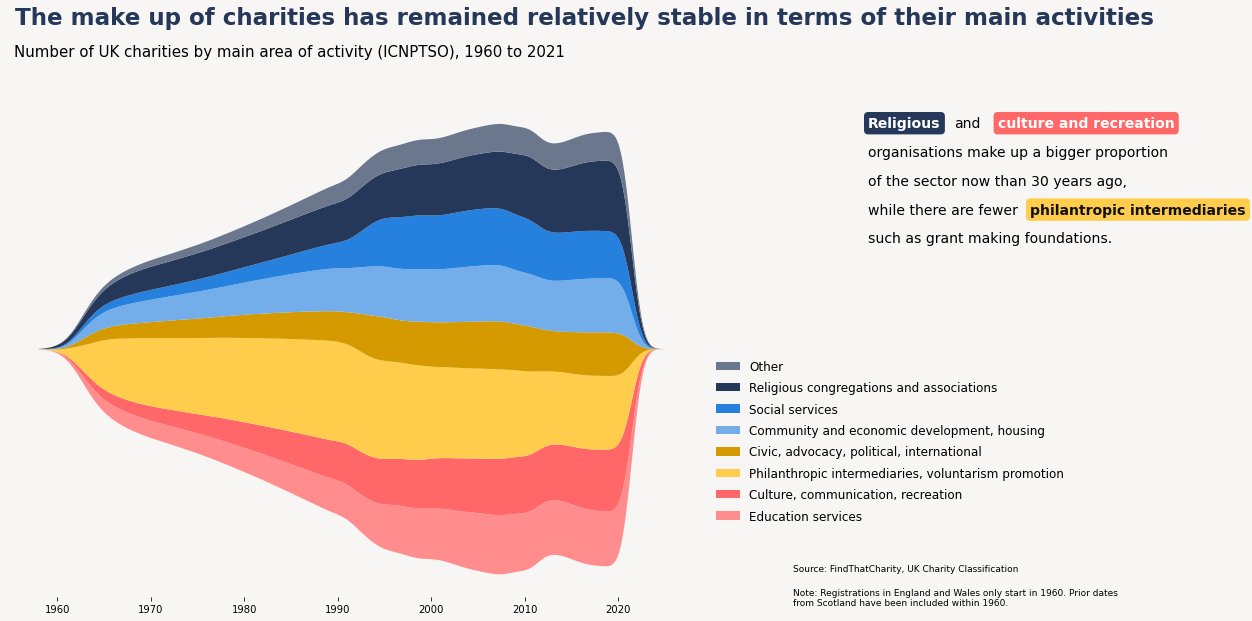

In [483]:


# =========================
# Create chart area

# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)

#remove chart area frame
ax.set_frame_on(False)
#ax.set_facecolor("#f7f6f4") # change chart background colour to white

#set background colour for whole viz
fig.set_facecolor("#f7f6f4")

#remove y-axis
ax.axes.get_yaxis().set_visible(False)

# =======
#input data

#years
x = np.arange(1960, 2022) 

# y-values to map
columns = ['Education services',
       'Culture, communication and recreation activities',
       'Philanthropic intermediaries and voluntarism promotion',
       'Civic, advocacy, political and international activities',
       'Community and economic development, and housing activities',
       'Social services', 'Religious congregations and associations',
           'Other'] 
y = [char_year_icnptso[column].tolist() for column in columns]


# =======
# Look of streamgraph

#smooth lines 
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

#define colours
colours = ["#ff8d8d",  "#ff6768", "#ffcd4b", "#d59a00", "#74aeea", "#2580de","#263859", "#6b778d"]

# =======
# Add title and subtitle
plt.suptitle("The make up of charities has remained relatively stable in terms of their main activities", 
             size=23, y=1.06, ha='left', x=0.01, fontweight='bold', color=colours[6],
            fontfamily='Oswald')


plt.title("Number of UK charities by main area of activity (ICNPTSO), 1960 to 2021", 
          size=15, y=1.08, ha='left', x=0.01)

# =======
# display chart
labels_display = ['Education services',
       'Culture, communication, recreation',
       'Philanthropic intermediaries, voluntarism promotion',
       'Civic, advocacy, political, international',
       'Community and economic development, housing',
       'Social services', 'Religious congregations and associations',
           'Other'] 


grid = np.linspace(1958, 2025, num=500)
y_smoothed = [gaussian_smooth(x, y_, grid, 1) for y_ in y]
ax.stackplot(grid, y_smoothed, colors = colours, baseline="sym", labels=labels_display);


#===========
#add legend in reverse order to match chart

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [7,6,5,4,3,2,1,0]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
            bbox_to_anchor=(1.55,0.5), frameon=False, labelspacing=0.7, fontsize=12, loc='upper right')

#=========
#source + note
fig.text(0.73, 0.08, "Source: FindThatCharity, UK Charity Classification", fontsize=9)
fig.text(0.73, 0.02, "Note: Registrations in England and Wales only start in 1960. Prior dates \nfrom Scotland have been included within 1960.",
         fontsize=9)


#=========
#annotations

#religious
fig.text(0.8, 0.85, 'Religious',
         fontsize = 14,
         weight = 'bold',
         color = 'white',
         bbox ={'facecolor':colours[6],
                'boxstyle':'round',
                'linewidth':0,
                'pad':0.3})

fig.text(0.88, 0.85, 'and',
         fontsize = 14,
         weight = 'normal')
         #color = 'white',

    
fig.text(0.92, 0.85, 'culture and recreation',
         fontsize = 14,
         weight = 'bold',
         color = 'white',
         bbox ={'facecolor':colours[1],
                'boxstyle':'round',
                'linewidth':0,
                'pad':0.3})

fig.text(0.8, 0.8, 'organisations make up a bigger proportion',
         fontsize = 14,
         weight = 'normal')

fig.text(0.8, 0.75, 'of the sector now than 30 years ago,',
         fontsize = 14,
         weight = 'normal')

fig.text(0.8, 0.7, 'while there are fewer',
         fontsize = 14,
         weight = 'normal')

fig.text(0.95, 0.7, 'philantropic intermediaries',
         fontsize = 14,
         weight = 'bold',
         color = '#111111',
         bbox ={'facecolor':colours[2],
                'boxstyle':'round',
                'linewidth':0,
                'pad':0.3})

fig.text(0.8, 0.65, 'such as grant making foundations.',
         fontsize = 14,
         weight = 'normal')


#save output
plt.savefig('number-charities-by-icnptso-streamgraph.png', bbox_inches='tight', pad_inches=0.5)